# Import and authentication

## Libraries Import

In [166]:
pip install googleapis-common-protos protobuf grpcio pandas systemathics.apis statsmodels matplotlib seaborn scipy

Note: you may need to restart the kernel to use updated packages.


In [167]:
import os
import re
import grpc
import pandas as pd
import seaborn
import statsmodels.api as sm
import google.protobuf as pb
import systemathics.apis.services.static_data.v1.static_data_pb2 as static_data
import systemathics.apis.services.static_data.v1.static_data_pb2_grpc as static_data_service
import numpy as np
from statsmodels.tsa.stattools import adfuller,coint
import matplotlib.pyplot as plt
import systemathics.apis.type.shared.v1.identifier_pb2 as identifier
import systemathics.apis.services.daily.v1.daily_prices_pb2 as daily_prices
import systemathics.apis.services.daily.v1.daily_prices_pb2_grpc as daily_prices_service
from datetime import datetime
import itertools
import copy
from scipy.optimize import minimize

## Authentication Token

In [168]:
token = f"Bearer {os.environ['AUTH0_TOKEN']}"
display(token)

'Bearer eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6ImpwZDhjS2Z5Zi13QXkzOURpNENqWSJ9.eyJodHRwOi8vc2NoZW1hcy54bWxzb2FwLm9yZy93cy8yMDA1LzA1L2lkZW50aXR5L2NsYWltcy9lbWFpbGFkZHJlc3MiOiJhcnRodXIudmlub3RAZWR1LmRldmluY2kuZnIiLCJpc3MiOiJodHRwczovL2dhbnltZWRlLXByb2QuZXUuYXV0aDAuY29tLyIsInN1YiI6ImF1dGgwfDYxNmQ4NzI5NWQzZDlkMDA3MGVkYmIxNCIsImF1ZCI6WyJodHRwczovL3Byb2QuZ2FueW1lZGUtcHJvZCIsImh0dHBzOi8vZ2FueW1lZGUtcHJvZC5ldS5hdXRoMC5jb20vdXNlcmluZm8iXSwiaWF0IjoxNjQ3Nzc0MzYyLCJleHAiOjE2NTAzNjYzNjIsImF6cCI6Ijl5R0tzbGtFczFWNm9xRk9aa0h0a1V0NWkyNTVackpJIiwic2NvcGUiOiJvcGVuaWQgcHJvZmlsZSBlbWFpbCIsInBlcm1pc3Npb25zIjpbImFkbWluIiwiYXJ0ZWZhY3RzIiwiY2hhbmdlcyIsImNvbXBvbmVudHMiLCJkYWlseV9iYXJzIiwiZGFpbHlfYm9sbGluZ2VyIiwiZGFpbHlfY21hIiwiZGFpbHlfZW1hIiwiZGFpbHlfbWFjZCIsImRhaWx5X3ByaWNlcyIsImRhaWx5X3JzaSIsImRhaWx5X3NtYSIsImRhaWx5X3ZvbGF0aWxpdHkiLCJkYWlseV92d2FwcyIsImRpdmlkZW5kcyIsImlkZW50aWZpZXJfbWFwcGluZyIsImludHJhZGF5X2JhcnMiLCJpbnRyYWRheV9ib2xsaW5nZXIiLCJpbnRyYWRheV9jbWEiLCJpbnRyYWRheV9lbWEiLCJpbnRyYWRheV9tYWNkIiw

# Pair Creation & Selection

## Indicators selection

### Correlation
We used the numpy library to calculate the correlation coefficient.

In [169]:
def correlation(timeseries1,timeseries2):
    return np.corrcoef(sample1_sum,sample2_sum)[0,1]
# Correlation need to be near 1

### Stationarity
In order to test stationarity we use the statsmodels library. It uses the Augmented Dickey-Fuller unit root test. The null hypothesis tested is thar there is a unit root. We then set a cut-off p-value to separate stationary and non-stationary time-series.

In [170]:
def stationarity_test_bool(timeseries,cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(timeseries, maxlag=3)[1]
    return True if pvalue<cutoff else False

In [171]:
def stationarity_test_pvalue(timeseries):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    return adfuller(timeseries, maxlag=3)[1]


### Cointegration

The cointegration test is made using the statsmodels library as well. But this time we use the augmented Engle-Granger tow-step cointegration test. The null hypothesis tested is no cointegration. The p-value serves as an indicator to determine if two times series are cointegrated.

In [172]:
def cointegration_test(timeseries1,timeseries2):
    return coint(timeseries1,timeseries2, maxlag=3)[1]    # return the p-value of the test


## Data gathering

We want to extract the data from the API in the best format possible so we first setup a template Dataframe to host the data. We then make request through the API to fill the Dataframe

### NASDAQ100 DataFrame

In [173]:
# Define a method to handle the equities reponse using a Pandas dataframe

def get_equities_dataframe(response):
    identifier = ['{0}|{1}'.format(equity.identifier.ticker, equity.identifier.exchange) for equity in response.equities]
    type = [equity.type for equity in response.equities]
    country = [equity.country for equity in response.equities]
    name = [equity.name for equity in response.equities]
    currency = [equity.currency for equity in response.equities]
    primary = [equity.primary for equity in response.equities]
    tick_size_rule = [equity.tick_size_rule for equity in response.equities]
    mapping = [get_mapping(equity.mapping) for equity in response.equities]
    index = [equity.index for equity in response.equities]
    open = [equity.open for equity in response.equities]
    close = [equity.close for equity in response.equities]
    time_zone = [equity.time_zone for equity in response.equities]
    lot_size = [equity.lot_size for equity in response.equities]
    point_value = [equity.point_value for equity in response.equities]
    isin = [equity.isin for equity in response.equities]
    cusip = [equity.cusip for equity in response.equities]
    sedol = [equity.sedol for equity in response.equities]
    sectors = [get_sectors(equity.sectors) for equity in response.equities]
    capitalization = [equity.capitalization.value for equity in response.equities]
    
    # Create pandas dataframe
    d = {'Identifier': identifier, 'Type': type, 'Country': country, 'Name': name, 'Currency': currency, 'Primary': primary, 'TickSizeRule': tick_size_rule, 'Mapping':mapping, 'Index': index, 'Open': open, 'Close': close, 'Time zone': time_zone, 'Lot size': lot_size, 'PointValue': point_value, 'Isin': isin, 'Cusip': cusip, 'Sedol': sedol, 'Sectors': sectors, 'Capitalization': capitalization}
    df = pd.DataFrame(data=d)
    return df

In [174]:
# Define methods to handle identifiers mapping and sectors display as a string

def get_mapping(d):
    res=''
    for key, value in d.items():
        res = res + '['+key+'='+value+']'
    return res

def get_sectors(d):
    res=''
    for key, value in d.items():
        res = res + '['+key+','+value+']'
    return res

def get_identifier(d):
    res=''
    for key, value in d.items():
        res = res + '['+key+'='+value+']'
    return res

In [175]:
# Generate static data API requests

request = static_data.StaticDataRequest( 
    asset_type = static_data.AssetType.ASSET_TYPE_EQUITY
)

#request.index.value = 'Nasdaq 100'
request.exchange.value = 'XNGS'     # This value is only filtering the primary exchange thus not filtering Nasdaq100 assets traded on the Bats Global Markets (BATS)
request.count.value = 1000          # and on the NASDAQ.


<h4> API Request and classification </h4>

The below API call is used to get all informations on the assets in the **selected Stock Exchange and Index**.
We then get a Dataframe used to summarise all these data. We will use this Dataframe later to extract the tickers name of the *NASDAQ100*.
Equities are also divided in various categories in respect to the **primary activity** of the company. We choose the *Standard Industrial Classification* (**SIC**) to **categorize** our differents assets.

In [176]:
# open a gRPC channel
with open(os.environ['SSL_CERT_FILE'], 'rb') as f:
    credentials = grpc.ssl_channel_credentials(f.read())
with grpc.secure_channel(os.environ['GRPC_APIS'], credentials) as channel:
    
    # instantiate the static data service
    service = static_data_service.StaticDataServiceStub(channel)
    
    # process the request
    response = service.StaticData(request = request, metadata = [('authorization', token)])

# visualize request results
data = get_equities_dataframe(response)

data = data[data.Identifier.str.split('|').str[1] == "XNGS"]        # These two lines solves the problems of filtering on exchange
data = data[data.Index.str.contains(r"Nasdaq 100") == True]         # and on the index

data.sort_values('Identifier')

,Identifier,Type,Country,Name,Currency,Primary,TickSizeRule,Mapping,Index,Open,Close,Time zone,Lot size,PointValue,Isin,Cusip,Sedol,Sectors,Capitalization
41,AAPL|XNGS,Equity,US,Apple Inc,USD,XNGS,[0:0.0001][1:0.01],[Idc|564=564|AAPL][Figic=BBG000B9XRY4][Bloombe...,Composite|Industrials|Nasdaq 100|Nasdaq Compos...,,,,1,1.0,US0378331005,037833100,2046251,"[Nasdaq,Computer Manufacturing][SIC,3571 Elect...",2.867249e+12
114,ABNB|XNGS,Equity,US,Airbnb Inc Cl A,USD,XNGS,[0:0.0001][1:0.01],[Figi=BBG001Y2XS07][Reuters=ABNB.OQ][Esignal=A...,Nasdaq 100|Nasdaq Composite|nasdaq100,,,,1,1.0,US0090661010,009066101,BMGYYH4,"[Nasdaq,Other Consumer Services][SIC,7340 Serv...",9.649736e+10
5,ADBE|XNGS,Equity,US,Adobe Inc,USD,XNGS,[0:0.0001][1:0.01],[Reuters=ADBE.OQ][Figic=BBG000BB5006][Idc|564=...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US00724F1012,00724F101,2008154,"[SIC,7372 Services-Prepackaged Software][Nasda...",2.142536e+11
44,ADI|XNGS,Equity,US,Analog Devices Inc,USD,XNGS,[0:0.0001][1:0.01],[Idc|564=564|ADI][Figi=BBG000BB6G37][Bloomberg...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US0326541051,032654105,2032067,"[Nasdaq,Semiconductors][SIC,3674 Semiconductor...",8.593881e+10
21,ADP|XNGS,Equity,US,Automatic Data Processing Inc,USD,XNGS,[0:0.0001][1:0.01],[Bloomberg=ADP US Equity][Figic=BBG000JG0547][...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US0530151036,053015103,2065308,"[Nasdaq,Business Services][SIC,7374 Services-C...",8.927222e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,WBA|XNGS,Equity,US,Walgreens Boots Alliance Inc,USD,XNGS,[0:0.0001][1:0.01],[Figi=BBG000BWLMJ4][Bloomberg=WBA US Equity][E...,Composite|Industrials|Nasdaq 100|Nasdaq Compos...,,,,1,1.0,US9314271084,931427108,BTN1Y44,"[SIC,5912 Retail-Drug Stores and Proprietary S...",4.090183e+10
23,WDAY|XNGS,Equity,US,Workday Inc,USD,XNGS,[0:0.0001][1:0.01],[Reuters=WDAY.OQ][Idc|564=564|WDAY][Figi=BBG00...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US98138H1014,98138H101,B8K6ZD1,"[Nasdaq,Computer Software: Prepackaged Softwar...",6.095284e+10
8,XEL|XNGS,Equity,US,Xcel Energy Inc,USD,XNGS,[0:0.0001][1:0.01],[Idc|564=564|XEL][Reuters=XEL.OQ][Figic=BBG000...,Composite|Nasdaq 100|Nasdaq Composite|Russell ...,,,,1,1.0,US98389B1008,98389B100,2614807,"[Nasdaq,Power Generation][SIC,4931 Electric & ...",3.772490e+10
71,ZM|XNGS,Equity,US,Zoom Video Communications Cl A,USD,XNGS,[0:0.0001][1:0.01],[Idc|564=564|ZM][Figi=BBG0042V6JM8][Esignal=ZM...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US98980L1017,98980L101,BGSP7M9,"[SIC,7370 Services-Computer Programming, Data ...",3.495862e+10



#### Get Ticker List

We get the ticker list that is to say the list of all equities belonging to the NASDAQ100 index. We will use this list to make price requests for each equity.

In [177]:
def get_ticker_list(data):
    return data.Identifier.str.split('|').str[0].tolist()

In [178]:
ticker_list = get_ticker_list(data)


#### Equities Classification (*SIC*)

This part gets the SIC code in the *Sectors* column of the above Dataframe. The *Standard Industrial Classification* **is made of 4 digits** and the further you go in those digits the **further you specialize**. For example all companies having their SIC code beginning by 0 belong to the *Agricultural, Forestry and Fishing Sectors* but if their second digit is 8 then we can infer that the company primary activity is Forestry. We only limit ourseleves to the **first two digits** of the *SIC* code in order to get a reasonable amount of SIC groups.

In [179]:
def get_sic(data):
    sic = []
    for i in range(len(data)):
        ligne = data.iloc[i]['Sectors']
        match = re.search(r"SIC,([0-9]{2})", ligne)
        sic.append(match.group().split(",")[1])
    data['SIC'] = sic
    return data

In [180]:
data = get_sic(data)


#### Sectors Separation

We create a **list of Dataframes** with each Dataframe containing the information of the equities belonging to the **same group** *(ie. having the same SIC code two first digits)*.

In [181]:
def sep_secteur(data):
    groups = data.groupby(['SIC'])
    liste_sic = data['SIC'].unique()
    liste_sic.sort()
    df_SIC = []
    for i in range(len(liste_sic)):
        df_SIC.append(groups.get_group(liste_sic[i]))
    return df_SIC

In [182]:
data_sec = sep_secteur(data)

In [183]:
data_sec[0]

,Identifier,Type,Country,Name,Currency,Primary,TickSizeRule,Mapping,Index,Open,Close,Time zone,Lot size,PointValue,Isin,Cusip,Sedol,Sectors,Capitalization,SIC
15,MNST|XNGS,Equity,US,Monster Beverage Cp,USD,XNGS,[0:0.0001][1:0.01],[Idc|564=564|MNST][Figic=BBG008NVB1C0][Reuters...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US61174X1090,61174X109,BZ07BW4,"[Nasdaq,Beverages (Production/Distribution)][S...",4.181935e+10,20
91,MDLZ|XNGS,Equity,US,Mondelez International Ord Shs Class A,USD,XNGS,[0:0.0001][1:0.01],[Reuters=MDLZ.OQ][Figic=BBG000D4LWF6][Figi=BBG...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US6092071058,609207105,B8CKK03,"[SIC,2000 Food and Kindred Products][Nasdaq,Me...",8.520169e+10,20
96,PEP|XNGS,Equity,US,Pepsico Inc,USD,XNGS,[0:0.0001][1:0.01],[Figi=BBG000DH7JK6][Bloomberg=PEP US Equity][I...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US7134481081,713448108,2681511,"[Nasdaq,Beverages (Production/Distribution)][S...",2.248939e+11,20
99,KHC|XNGS,Equity,US,Kraft Heinz Company,USD,XNGS,[0:0.0001][1:0.01],[Bloomberg=KHC US Equity][Esignal=KHC][Reuters...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US5007541064,500754106,BYRY499,"[SIC,2030 Canned, Frozen & Preserved Fruit, Ve...",4.603711e+10,20
132,KDP|XNGS,Equity,US,Keurig Dr Pepper Inc Common Stock,USD,XNGS,[0:0.0001][1:0.01],[Figic=BBG000TJM7F0][Figi=BBG000TJM7F0][Bloomb...,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,,,,1,1.0,US49271V1008,49271V100,BD3W133,"[SIC,2080 Beverages][Nasdaq,Beverages (Product...",5.357802e+10,20


We also create a list only containing the **name of the equities grouped by SIC**.

In [184]:
sic_list = [get_ticker_list(groupe) for groupe in data_sec]

In [185]:
sic_list[0]

['MNST', 'MDLZ', 'PEP', 'KHC', 'KDP']


## Pair Creation

We want to limit the pairs created to companies of the **same sectors**, that is why we used the SIC code to classify all the equities of the NASDAQ100. Using the equities list created above separating equities by SIC code we create all the possible combination of pairs. *For example in a group of 3 equities (A, B and C) we create the following pairs => A/B , A/C and B/C*.

We then get a list of tuple describing **all the possible pairs combinations**.

### Creation of all possible combination for each group

In [186]:
def list_combinations(liste_paires):
    combi = []
    for i in range(len(liste_paires)):
        combi.append(list(itertools.combinations(liste_paires[i],2)))
    return [x for sublist in combi for x in sublist if x != []]

In [187]:
combinations = list_combinations(sic_list)


### Price request for each pair

We make an api call for each ticker, requesting prices over the longest time period possible. 

#### Fonction qui va requêter les prix à travers l'API

In [188]:
def price_request(ticker, exchange):
    request = daily_prices.DailyPricesRequest( identifier = identifier.Identifier(exchange = exchange, ticker = ticker))
    
    # open a gRPC channel
    with open(os.environ['SSL_CERT_FILE'], 'rb') as f:
        credentials = grpc.ssl_channel_credentials(f.read())
    with grpc.secure_channel(os.environ['GRPC_APIS'], credentials) as channel:

        # instantiate the daily prices service
        service = daily_prices_service.DailyPricesServiceStub(channel)

        # process the daily prices request
        return service.DailyPrices(request = request, metadata = [('authorization', token)])


#### Cache

We store the prices for each ticker in a cache so we don't have to call the API every time we need the prices for a given equity.

In [189]:
%%time
cache = pd.DataFrame({'Name' : ticker_list, 'Data' : [price_request(x, 'XNGS') for x in ticker_list]})

CPU times: user 3.05 s, sys: 599 ms, total: 3.65 s
Wall time: 36 s


We request the price **for each pair** by calling the cache. For each pair we use the largest time frame available *(ie. the smallest of the two)*. We store all the prices in a **list of Dataframe** containing 3 columns *(Date, Price_A, Price_B)*. We drop the pairs having **less than a hundred data points** as we considered them as inexploitable.

In [190]:
def df_paire(paire, exchange, cache):
    response1 = cache.iloc[int(cache.index[cache['Name'] == paire[0]].values), 1]
    response2 = cache.iloc[int(cache.index[cache['Name'] == paire[1]].values), 1]
    
    # prepare the dataframe content
    dates1 = [datetime(p.date.year, p.date.month, p.date.day) for p in response1.data]
    dates2 = [datetime(p.date.year, p.date.month, p.date.day) for p in response2.data]
    if (len(dates1) <= len(dates2)):
        dates = dates1
    else:
        dates = dates2
    prices1 = [p.price for p in response1.data][-len(dates):]       # So all arrays have the same length
    prices2 = [p.price for p in response2.data][-len(dates):]

    d = {'Date': dates, f'{paire[0]}': prices1, f'{paire[1]}': prices2}
    return pd.DataFrame(data=d)

In [191]:
def pair_combination(combinations, exchange, cache):
    temp = [df_paire(x, exchange, cache) for x in combinations]
    return [x for x in temp if len(x) > 100]

In [192]:
%%time
df_combi = pair_combination(combinations, 'XNGS', cache)

CPU times: user 23.5 s, sys: 33.1 ms, total: 23.6 s
Wall time: 23.7 s


## Séparation entre les données de test et celles d'entrainement

#### Data Splitting

In [193]:
def addMonths(date):
    b = pd.Timestamp(date) + pd.DateOffset(months=1)
    return b

In [194]:
def subtractMonths(date):
    b = pd.Timestamp(date) - pd.DateOffset(months=1)
    return b

In [195]:
def sep_tableau_train_test(df, train_start_date, train_end_date, test_end_date):    # Séparation entre les données de test et de train
    test_start_date = train_end_date
    
    test = []
    train = []
    for i in range(len(df)):
        if (df[i].Date.iloc[0] <= train_start_date):
            train_date = (df[i]['Date'] >= train_start_date) & (df[i]['Date'] < train_end_date)
            test_date = (df[i]['Date'] >= test_start_date) & (df[i]['Date'] <= test_end_date)
            train.append(df[i].loc[train_date])
            test.append(df[i].loc[test_date])
            
    return train, test

In [196]:
train_start_date = np.datetime64('2014-01-01')
train_end_date = np.datetime64('2019-01-01')
test_end_date = np.datetime64('2021-01-01')

In [197]:

train, test = sep_tableau_train_test(df_combi, train_start_date, train_end_date, test_end_date)

In [198]:
### Calcul du nombre de Paires crées
"Nombre de paires = " + str(len(test))   # Nombre de paires

'Nombre de paires = 328'

In [199]:
list(train[0].columns)[:3]

['Date', 'MNST', 'MDLZ']

## Fonctions de Sélections des paires

#### Calcul de la cointégration

In [200]:
def coint_df(df):
    df['Cointegration'] = pd.Series(cointegration_test(df.iloc[:,1], df.iloc[:,2]), index = df.index[[0]])
    return df

In [201]:
def add_coint(df_combi):
    return [coint_df(x) for x in df_combi]

#### Calcul de la stationnarité

In [202]:
def statio_df(df, column_name, indicateur):
    df[column_name] = pd.Series(stationarity_test_pvalue(df[indicateur]), index = df.index[[0]])
    return df

In [203]:
def add_statio(df, column_name, indicateur):
    return [statio_df(x, column_name, indicateur) for x in copy.deepcopy(df)]

#### Calcul du ratio

In [204]:
def ratio_df(df):
    df['Ratio'] = df.iloc[:,1] / df.iloc[:,2]
    return df

In [205]:
def add_ratio_list_df(df):
    return add_statio(df, 'Statio_Ratio', 'Ratio')

#### Calcul du log-ratio

In [206]:
def log_ratio_df(df):
    df['Log_Ratio'] = np.log(df.iloc[:,1] / df.iloc[:,2])
    return df

In [207]:
def add_log_list_df(df):
    return add_statio(df, 'Statio_Log_Ratio', 'Log_Ratio')

##### Ajout des ratios au df

In [208]:
def add_ratios(df):
    df_copy = [ratio_df(x) for x in copy.deepcopy(df)]
    return [log_ratio_df(x) for x in df_copy]

#### Fonction qui enlève les paires peu cointégrées

In [209]:
def drop_faible_coint(train, threshold):    # Retourne une liste de paires suffisament cointégrés
    return [x for x in train if (x['Cointegration'].iloc[0] < threshold)]

#### Fonction qui enlève les paires dont les 2 indicateurs sont non-stationnaires

In [210]:
def drop_faible_statio(df_combi, threshold):    # Retourne une liste de paires suffisament cointégrés
    df_combi_copy = []
    count_ratio = 0
    count_log = 0
    same = 0

    for x in df_combi:
        if x['Statio_Ratio'].iloc[0] < threshold:     # On compte le nombre de stationnarité acceptable entre le ratio classique et le log_ratio
            count_ratio += 1
        if x['Statio_Log_Ratio'].iloc[0] < threshold:
            count_log += 1
        if x['Statio_Log_Ratio'].iloc[0] < threshold and x['Statio_Ratio'].iloc[0] < threshold:
            same += 1
            
    return [x for x in df_combi if (x['Statio_Log_Ratio'].iloc[0] < threshold)], count_ratio, count_log, same

#### Cointégration

In [211]:
%%time
df_coint = add_coint(train)
print(df_coint)

/tmp/ipykernel_161/2820075488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cointegration'] = pd.Series(cointegration_test(df.iloc[:,1], df.iloc[:,2]), index = df.index[[0]])
/tmp/ipykernel_161/2820075488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cointegration'] = pd.Series(cointegration_test(df.iloc[:,1], df.iloc[:,2]), index = df.index[[0]])
/tmp/ipykernel_161/2820075488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

[           Date       MNST   MDLZ  Cointegration
3157 2014-01-02  22.259998  34.81       0.219159
3158 2014-01-03  22.506664  34.75            NaN
3159 2014-01-06  22.153331  34.53            NaN
3160 2014-01-07  22.579998  34.81            NaN
3161 2014-01-08  22.796664  34.82            NaN
...         ...        ...    ...            ...
4410 2018-12-24  47.950000  39.48            NaN
4411 2018-12-26  49.100000  40.00            NaN
4412 2018-12-27  49.440000  40.23            NaN
4413 2018-12-28  49.040000  39.89            NaN
4414 2018-12-31  49.220000  40.03            NaN

[1258 rows x 4 columns],            Date       MNST     PEP  Cointegration
3269 2014-01-02  22.259998   82.10       0.204124
3270 2014-01-03  22.506664   82.24            NaN
3271 2014-01-06  22.153331   82.28            NaN
3272 2014-01-07  22.579998   83.48            NaN
3273 2014-01-08  22.796664   83.24            NaN
...         ...        ...     ...            ...
4522 2018-12-24  47.950000  106.03 

### Fonction qui agrège les différentes fonctions de sélection (Log-Ratio, Ratio, Stationnarité des indicateurs) et qui enlève les paires qui ne valident pas les critères.

In [212]:
def pair_selection(df_coint):
    df = [x for x in df_coint if (x['Cointegration'].iloc[0] < 0.05)]
    print("drop_faible_coint OK")
    df = add_ratios(df)
    print("Add_Ratios OK")
    df = add_log_list_df(df)
    print("Add_Log_List OK")
    df = add_ratio_list_df(df)
    print("Add_Ratio_List OK")
    return drop_faible_statio(df, 0.05)

In [213]:
def test_selection(train, test):
    train_list = [list(x.columns)[:3] for x in train]
    return [x for x in test if list(x.columns) in train_list]

In [214]:
def test_selection_full(train, test):
    return [x for x in test]

In [215]:
%%time
train, ratio_score, log_score, same = pair_selection(df_coint) # 7 paires
test = test_selection(train, test)

drop_faible_coint OK
Add_Ratios OK
Add_Log_List OK
Add_Ratio_List OK
CPU times: user 841 ms, sys: 14 ms, total: 855 ms
Wall time: 847 ms


In [216]:
# test[0]
# w = (test[2]['Date'] >= np.datetime64('2019-01-02')) & (test[2]['Date'] < np.datetime64('2019-02-01'))

# test[2]['Selected'] = w
# test[2]

In [217]:
test[2]

,Date,ADP,VRSK
2324,2019-01-02,130.14,108.65
2325,2019-01-03,126.21,105.33
2326,2019-01-04,131.24,109.98
2327,2019-01-07,130.53,110.09
2328,2019-01-08,131.30,111.07
...,...,...,...
2824,2020-12-24,176.56,201.23
2825,2020-12-28,176.61,207.98
2826,2020-12-29,174.87,205.67
2827,2020-12-30,173.81,205.78


In [218]:
train[0]

,Date,SWKS,NXPI,Cointegration,Ratio,Log_Ratio,Statio_Log_Ratio,Statio_Ratio
857,2014-01-02,27.40,43.92,0.004831,0.623862,-0.471827,0.018802,0.015793
858,2014-01-03,27.72,43.56,NaN,0.636364,-0.451985,NaN,NaN
859,2014-01-06,27.63,43.12,NaN,0.640770,-0.445085,NaN,NaN
860,2014-01-07,27.79,42.97,NaN,0.646730,-0.435826,NaN,NaN
861,2014-01-08,27.92,43.83,NaN,0.637007,-0.450975,NaN,NaN
...,...,...,...,...,...,...,...,...
2110,2018-12-24,62.78,67.71,NaN,0.927189,-0.075597,NaN,NaN
2111,2018-12-26,66.71,71.77,NaN,0.929497,-0.073112,NaN,NaN
2112,2018-12-27,67.72,73.01,NaN,0.927544,-0.075215,NaN,NaN
2113,2018-12-28,67.22,72.13,NaN,0.931928,-0.070499,NaN,NaN


## Score de la sélection des paires

In [219]:
"Score ratio = " + str(ratio_score) + " Score Log_Ratio = " + str(log_score) + " Same = " + str(same)

'Score ratio = 9 Score Log_Ratio = 8 Same = 8'

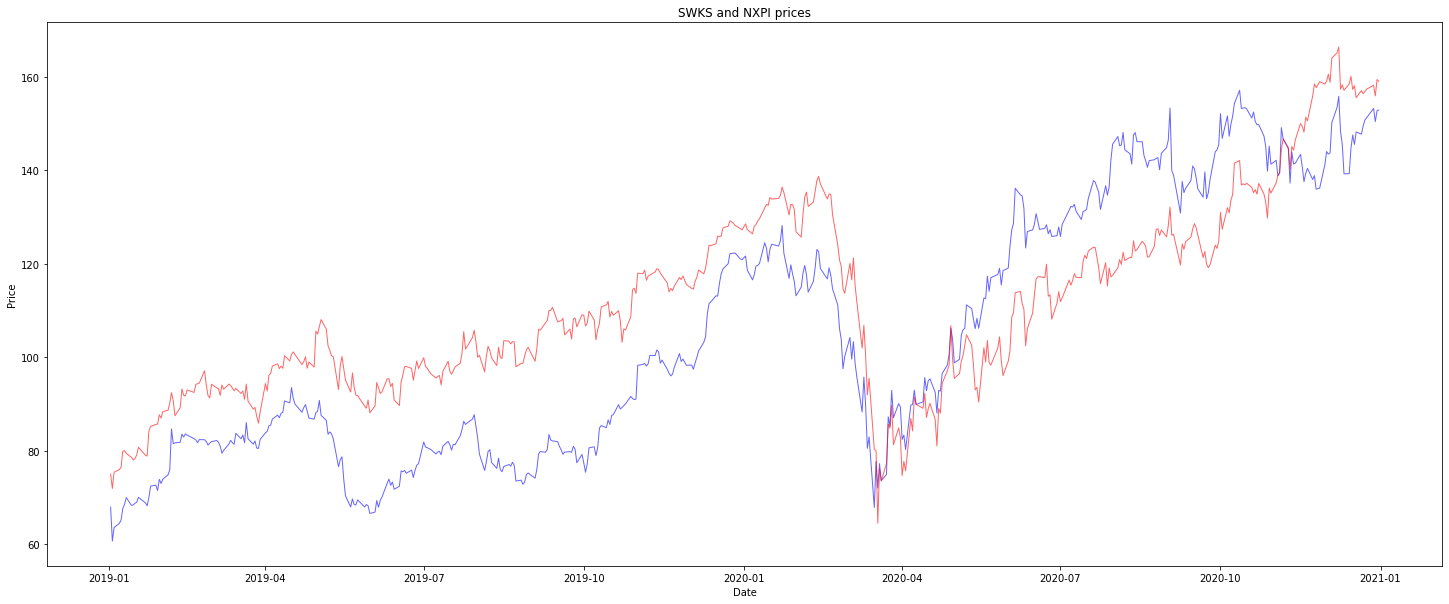

In [220]:
#We plot a random cointegrate pair to verify if everything is ok
plt.figure(figsize=(25, 10))
plt.plot('Date', test[0].columns[1], data=test[0], marker='', color='blue', linewidth=1, alpha = 0.6)
plt.plot('Date', test[0].columns[2], data=test[0], marker='', color='red', linewidth=1, alpha = 0.6)
plt.ylabel('Price')
plt.xlabel('Date')
plt.title("{} and {} prices".format(test[0].columns[1],test[0].columns[2]))
plt.show()

# Investissement

In [221]:
def calcul_moyenne_mobile(liste_df,window):
    liste_df = [log_ratio_df(df) for df in liste_df]
    #liste_df = [ratio_df(df) for df in liste_df]
    
    for i in range(len(liste_df)):
        # Calcul de la moyenne mobile
        rolling_window = liste_df[i]['Log_Ratio'].rolling(window=window, center=False)
        rolling_window_mean = rolling_window.mean()
        rolling_window_std  = rolling_window.std()

        Z_score_rolling = (liste_df[i]['Log_Ratio'] - rolling_window_mean) / rolling_window_std
        liste_df[i]['Zscore_rolling'] = Z_score_rolling
    return liste_df


In [222]:
window = 30
test = calcul_moyenne_mobile(test,window)
#train = calcul_moyenne_mobile(train)



/tmp/ipykernel_161/1567542809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log_Ratio'] = np.log(df.iloc[:,1] / df.iloc[:,2])
/tmp/ipykernel_161/1567542809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log_Ratio'] = np.log(df.iloc[:,1] / df.iloc[:,2])
/tmp/ipykernel_161/1567542809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [223]:
print(test[1])

           Date     TSLA     HON  Log_Ratio  Zscore_rolling
2142 2019-01-02   62.024  131.83  -0.753992             NaN
2143 2019-01-03   60.072  130.07  -0.772529             NaN
2144 2019-01-04   63.538  134.62  -0.750818             NaN
2145 2019-01-07   66.992  135.37  -0.703439             NaN
2146 2019-01-08   67.070  135.09  -0.700204             NaN
...         ...      ...     ...        ...             ...
2642 2020-12-24  661.770  209.53   1.150051        1.036930
2643 2020-12-28  663.690  209.94   1.150993        0.997561
2644 2020-12-29  665.990  209.13   1.158319        1.032840
2645 2020-12-30  694.780  210.95   1.191974        1.385887
2646 2020-12-31  705.670  212.70   1.199265        1.499036

[505 rows x 5 columns]


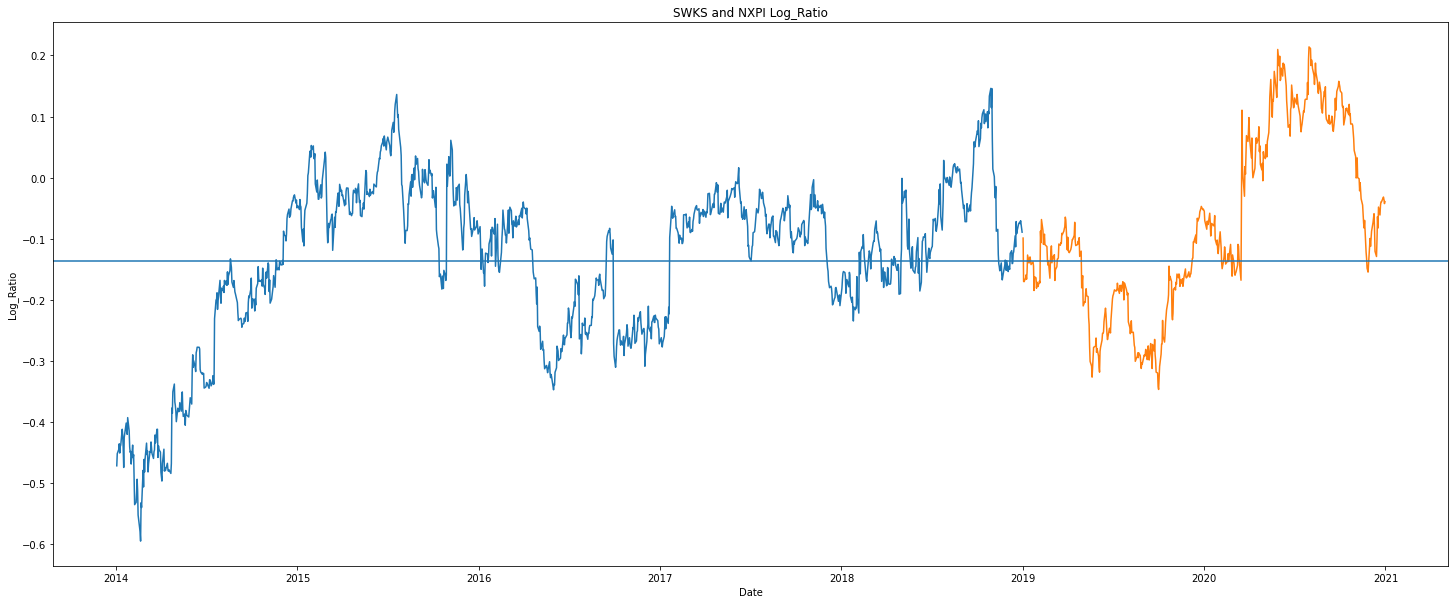

In [224]:
#We plot a random cointegrate pair to verify if everything is ok
plt.figure(figsize=(25, 10))
plt.plot('Date','Log_Ratio', data=train[0])
plt.plot('Date','Log_Ratio', data=test[0])
plt.axhline(train[0].Log_Ratio.mean())
plt.ylabel('Log_Ratio')
plt.xlabel('Date')
plt.title("{} and {} Log_Ratio".format(test[0].columns[1],test[0].columns[2]))
plt.show()

/tmp/ipykernel_161/502974839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[0]['Mean_Log_Ratio'] = test[0]['Log_Ratio'].rolling(window = 100).mean()
/tmp/ipykernel_161/502974839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[0]['STD_Log_Ratio'] = test[0]['Log_Ratio'].rolling(window = 100).std() * np.sqrt(256)


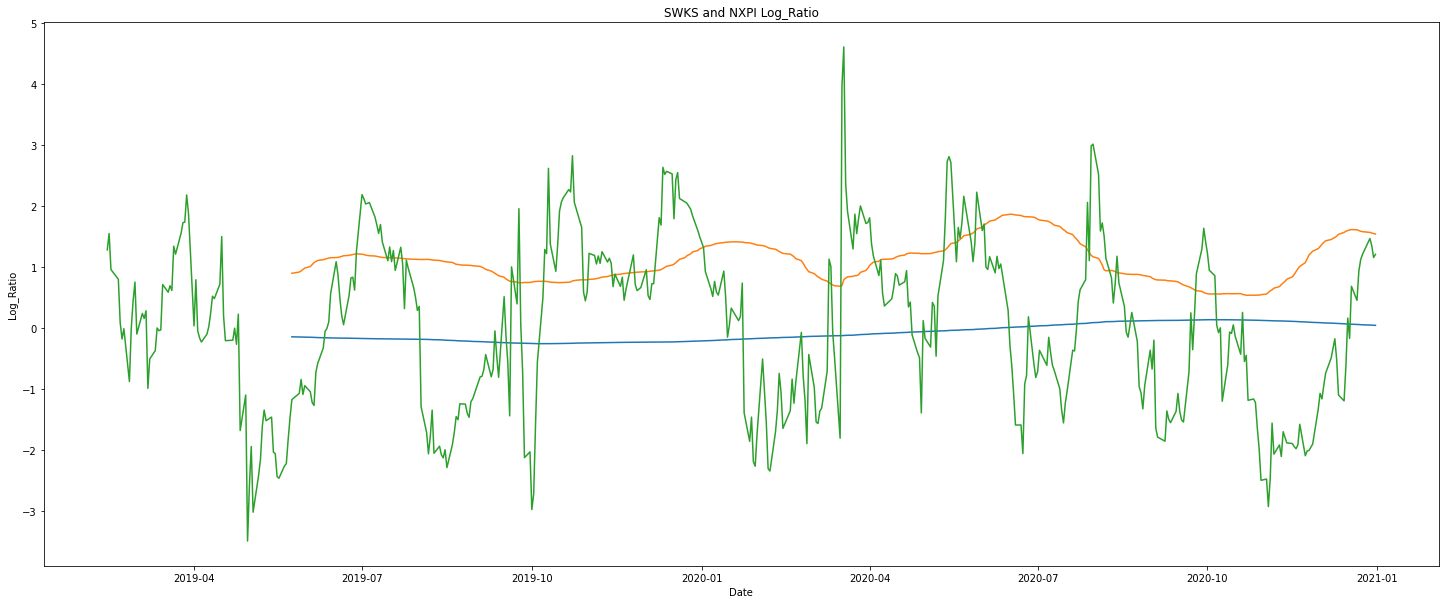

In [225]:
plt.figure(figsize=(25, 10))
test[0]['Mean_Log_Ratio'] = test[0]['Log_Ratio'].rolling(window = 100).mean()
test[0]['STD_Log_Ratio'] = test[0]['Log_Ratio'].rolling(window = 100).std() * np.sqrt(256)
plt.plot('Date','Mean_Log_Ratio', data=test[0])
plt.plot('Date','STD_Log_Ratio', data=test[0])
plt.plot('Date','Zscore_rolling', data=test[0])
'''
plt.axhline(test[0]['Mean_Log_Ratio'].values)
plt.axhline(test[0]['STD_Log_Ratio'].values)
'''
plt.ylabel('Log_Ratio')
plt.xlabel('Date')
plt.title("{} and {} Log_Ratio".format(test[0].columns[1],test[0].columns[2]))
plt.show()

In [226]:
def graph_invest(df):
    # Band
    # Z-Score
    df["2STD_Log_Ratio"] = 2.5 * df['STD_Log_Ratio']
    df["-2STD_Log_Ratio"] = -2.5 * df['STD_Log_Ratio']
    df["-STD_Log_Ratio"] = -df['STD_Log_Ratio']
    
    plt.figure(figsize=(25, 10))
    plt.plot('Date', 'Zscore_rolling', data=df, marker='', color='blue', linewidth=1, alpha =  0.6, label='Zscore_rolling')
    plt.plot('Date', 'STD_Log_Ratio', data=df, marker='', color='green', linewidth=1, alpha =  0.6, label='1')
    plt.plot('Date', '2STD_Log_Ratio', data=df, marker='', color='red', linewidth=1, alpha =  0.6, label='2')
    plt.plot('Date', '-STD_Log_Ratio', data=df, marker='', color='green', linewidth=1, alpha =  0.6, label='3')
    plt.plot('Date', '-2STD_Log_Ratio', data=df, marker='', color='red', linewidth=1, alpha =  0.6, label='4')

    day_count = 0
    position = False 
    
    for i in range(len(df)):
        day_count += 1
        if abs(df.Zscore_rolling.iloc[i]) > 2 * df['STD_Log_Ratio'].iloc[i] and position == True: # Stop loss
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='red', linestyle='None', marker='o')
            position = False
            day_count = 0
        
        elif day_count > 50:
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='grey', linestyle='None', marker='o')
            day_count = 0

        elif abs(df.Zscore_rolling.iloc[i]) > df['STD_Log_Ratio'].iloc[i] and abs(df.Zscore_rolling.iloc[i]) < 2 * df['STD_Log_Ratio'].iloc[i] and position == False and (-df['STD_Log_Ratio'].iloc[i] <= df['Zscore_rolling'].iloc[i-1] <= df['STD_Log_Ratio'].iloc[i]): # Entry Rule
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='green', linestyle='None', marker='^')
            position = True
            day_count = 0
        
        elif df.Zscore_rolling.iloc[i] * df.Zscore_rolling.iloc[i-1] < 0 and position == True: # Exit Rule
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='orange', linestyle='None', marker='s')
            position = False
            day_count = 0
        
        
        
            
    '''
    plt.axhline(df['STD_Log_Ratio'], color = 'green')
    plt.axhline(-df['STD_Log_Ratio'], color = 'green')
    plt.axhline(2*df['STD_Log_Ratio'], color = 'red')
    plt.axhline(-2*df['STD_Log_Ratio'], color = 'red')
    plt.axhline(df['Mean_Log_Ratio'], color = 'orange')
    '''
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.title("Zscore for pair {} and {}".format(df.columns[1],df.columns[2]))
    plt.show()
    

In [227]:
def graph_invest2(df, stoploss_value):
    # Band
    # Z-Score
    #plt.figure(figsize=(25, 10))
    #plt.plot('Date', 'Zscore_rolling', data=df, marker='', color='blue', linewidth=1, alpha =  0.6, label='Zscore_rolling')
    
    df["2STD_Log_Ratio"] =  stoploss_value * df['STD_Log_Ratio']
    df["-2STD_Log_Ratio"] = -stoploss_value * df['STD_Log_Ratio']
    df["-STD_Log_Ratio"] = -df['STD_Log_Ratio']
    
    plt.figure(figsize=(25, 10))
    plt.plot('Date', 'Zscore_rolling', data=df, marker='', color='blue', linewidth=1, alpha =  0.6, label='Zscore_rolling')
    plt.plot('Date', 'STD_Log_Ratio', data=df, marker='', color='green', linewidth=1, alpha =  0.6, label='1')
    plt.plot('Date', '2STD_Log_Ratio', data=df, marker='', color='red', linewidth=1, alpha =  0.6, label='2')
    plt.plot('Date', '-STD_Log_Ratio', data=df, marker='', color='green', linewidth=1, alpha =  0.6, label='3')
    plt.plot('Date', '-2STD_Log_Ratio', data=df, marker='', color='red', linewidth=1, alpha =  0.6, label='4')
    
    position = False 
    for i in range(len(df)):
        if (df.Status.iloc[i] == "Upper" or df.Status.iloc[i] == "Lower") and position == False: # Entry rule
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='green', linestyle='None', marker='o')
            position = True
        
        elif df.Status.iloc[i] == "Time Limit" and position == True: #Time limit
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='grey', linestyle='None', marker='o')
            position = False
            
        elif df.Status.iloc[i] == "Stop Loss" and position == True: # Stop loss 
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='red', linestyle='None', marker='^')
            position = False
        
        elif df.Status.iloc[i] == "Clear" and position == True: # Exit Rule
            plt.plot(df.Date.iloc[i], df.Zscore_rolling.iloc[i], color='orange', linestyle='None', marker='s')
            position = False
        
        
        
            
    '''
    plt.axhline(1, color = 'green')
    plt.axhline(-1, color = 'green')
    plt.axhline(2.5, color = 'red')
    plt.axhline(-2.5, color = 'red')
    '''
    plt.axhline(0, color = 'grey')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.title("Zscore for pair {} and {}".format(df.columns[1],df.columns[2]))
    plt.show()
    

In [228]:
#graph_invest2(df_test[1])

In [229]:
def selected(train,test,freq_reb,train_end_date,test_end_date): # à revoir 
    print(len(train))
    for i in range(len(test)):
        #reloop = False
        test[i]['selected'] = False
        current_date = addMonths(train_end_date)
        while current_date < test_end_date:# or reloop = False:
            train_split = train[i].iloc[:,:3]
            test_split = test[i].loc[(test[i]['Date'] >= train_end_date) & (test[i]['Date'] < current_date)]
            test_split = test_split.iloc[:,:3]
            df_train_concat = pd.concat([train_split,test_split], ignore_index=True)
            #df_train_concat['Cointegration'] = pd.Series(cointegration_test(df_train_concat.iloc[:,1], df_train_concat.iloc[:,2]), index = df_train_concat.index[[0]])
            #print(df_coint)
            #Stationnarité plutôt ici
            
            test[i]['selected'].loc[(test[i]['Date'] >= subtractMonths(current_date)) & (test[i]['Date'] < current_date)] = True
        #train, ratio_score, log_score, same = pair_selection(train)
            #train, test = sep_tableau_train_test(df_combi, train_start_date, train_end_date, test_end_date)
            
            current_date =  addMonths(current_date)
            
        train_split = train[i].iloc[:,:3]
        test_split = test[i].loc[(test[i]['Date'] >= train_end_date) & (test[i]['Date'] < current_date)]
        test_split = test_split.iloc[:,:3]
        df_train_concat = pd.concat([train_split,test_split], ignore_index=True)
            #df_train_concat['Cointegration'] = pd.Series(cointegration_test(df_train_concat.iloc[:,1], df_train_concat.iloc[:,2]), index = df_train_concat.index[[0]])
            #print(df_coint)
            
        test[i]['selected'].loc[(test[i]['Date'] >= subtractMonths(current_date)) & (test[i]['Date'] < current_date)] = True
        #print(test[i])
    
    return test

In [230]:
freq_reb=30
test = selected(train,test,freq_reb,train_end_date,test_end_date)

8


/tmp/ipykernel_161/1503062335.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]['selected'] = False
/tmp/ipykernel_161/1503062335.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]['selected'].loc[(test[i]['Date'] >= subtractMonths(current_date)) & (test[i]['Date'] < current_date)] = True
/tmp/ipykernel_161/1503062335.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [231]:
def invest2(df, entry_value, exit_value, stoploss_value, invest_value):
    vol_A = [0]
    vol_B = [0]
    total = [invest_value]
    #ratio = list(df.Ratio)
    price_A = list(df.iloc[:,1])
    price_B = list(df.iloc[:,2])
    day_count = 0
    count = [0]
    position = False
    status = ['']
    time_limit = 50
    cash = invest_value
    df['STD_Log_Ratio'] = df['Log_Ratio'].rolling(window = 50).std() * np.sqrt(256)
    mean_return = True
        
    # si on sort de position avec un zscore au dessus des limites, on va re-rentrer en position si il continue de monter, il faut empêcher ça
    #optimiser le code avec ligne utile boucle
    
    ###INSTAURER UN TAKE PROFIT
    
    for i in range(len(df)):
        if df["selected"].iloc[i] == True or df["Status"].iloc[i] == "Position":
            if np.sign(df['Zscore_rolling'].iloc[i]) != np.sign(df['Zscore_rolling'].iloc[i-1]) :
                mean_return = True
                
            if abs(df['Zscore_rolling'].iloc[i]) > stoploss_value * df['STD_Log_Ratio'].iloc[i] and  position == True:   # Stop-loss / Valeur absolue
                total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                cash = total[-1]
                vol_A.append(0)
                vol_B.append(0)
                day_count = 0
                count.append(day_count)
                position = False
                status.append("Stop Loss")
                mean_return = False #rendement diminue 

            elif df['Zscore_rolling'].iloc[i] * df['Zscore_rolling'].iloc[i-1]  < 0 and position == True:   # Clear Positions
                total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                cash = total[-1]
                vol_A.append(0)
                vol_B.append(0)
                day_count = 0
                count.append(day_count)
                position = False
                status.append("Clear")

            elif day_count > time_limit and position == True:    # Time-Limit
                total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                cash = total[-1]
                vol_A.append(0)
                vol_B.append(0)
                day_count = 0
                count.append(day_count)
                position = False
                status.append("Time Limit")

            elif ((df['Zscore_rolling'].iloc[i-1] > df['STD_Log_Ratio'].iloc[i]) and (df['Zscore_rolling'].iloc[i] < df['STD_Log_Ratio'].iloc[i]) and (0 < df['Zscore_rolling'].iloc[i] < df['STD_Log_Ratio'].iloc[i])) or position == True: #and (-entry_value <= df['Zscore_rolling'].iloc[i-1] <= entry_value):# and (df['Zscore_rolling'].iloc[i-1] > entry_value and df['Zscore_rolling'].iloc[i] < entry_value):#and (df['Zscore_rolling'].iloc[i] < df['Zscore_rolling'].iloc[i-1]) :    # Zscore above band (df['Zscore_rolling'].iloc[i] - df['Zscore_rolling'].iloc[i-1]) < 0
                if (position == False) and (mean_return == True):
                    vol_A.append(- (total[-1]/2) / price_A[i])           # Sell A
                    vol_B.append(+ (total[-1]/2) / price_B[i])       # Buy B
                    total.append(total[-1])#+ vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i]''')
                    position = True
                    day_count = 0
                    count.append(day_count)
                    status.append("Upper")
                else:
                    vol_A.append(vol_A[-1])
                    vol_B.append(vol_B[-1])
                    total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                    day_count += 1
                    count.append(day_count)
                    status.append("Position")

            elif ((df['Zscore_rolling'].iloc[i-1] < -df['STD_Log_Ratio'].iloc[i]) and (df['Zscore_rolling'].iloc[i] > -df['STD_Log_Ratio'].iloc[i]) and (-df['STD_Log_Ratio'].iloc[i] < df['Zscore_rolling'].iloc[i] < 0)) or position == True: #df['Zscore_rolling'].iloc[i] < -entry_value and (-entry_value <= df['Zscore_rolling'].iloc[i-1] <= entry_value):# and (df['Zscore_rolling'].iloc[i-1] < -entry_value and df['Zscore_rolling'].iloc[i] > -entry_value) : #and (df['Zscore_rolling'].iloc[i] > df['Zscore_rolling'].iloc[i-1]) :     # Zscore under band (df['Zscore_rolling'].iloc[i] - df['Zscore_rolling'].iloc[i-1]) < 0
                if (position == False) and (mean_return == True):
                    vol_A.append(+ (total[-1]/2) / price_A[i])          # Buy A
                    vol_B.append(- (total[-1]/2) / price_B[i])     # Sell B
                    total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                    position = True
                    day_count = 0
                    count.append(day_count)
                    status.append("Lower")
                else:
                    vol_A.append(vol_A[-1])
                    vol_B.append(vol_B[-1])
                    total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                    day_count += 1
                    count.append(day_count)
                    status.append("Position")
                
            elif position == True:
                vol_A.append(vol_A[-1])
                vol_B.append(vol_B[-1])
                total.append(cash + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                day_count += 1
                count.append(day_count)
                status.append("Position")
                
            else:
                vol_A.append(vol_A[-1])
                vol_B.append(vol_B[-1])
                total.append(total[-1])# + vol_A[-1] * price_A[i] + vol_B[-1] * price_B[i])
                day_count += 1
                count.append(day_count)
                status.append("No Position")
                
        else:
            vol_A.append(vol_B[-1])
            vol_B.append(vol_B[-1])
            total.append(total[-1])
            day_count += 1
            count.append(day_count)
            status.append("No position")
            

    df['Vol_A'] = vol_A[1:]
    df['Vol_B'] = vol_B[1:]
    df['Total'] = total[1:]
    df['Status'] = status[1:]
    df['Day_count'] = count[1:]
    
    return df

In [232]:
stoploss_value = 4
cash = 100000
df_test = [invest2(df, 1, 0, stoploss_value, cash/len(test)) for df in test]
df_test


/tmp/ipykernel_161/482993948.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STD_Log_Ratio'] = df['Log_Ratio'].rolling(window = 50).std() * np.sqrt(256)
/tmp/ipykernel_161/482993948.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vol_A'] = vol_A[1:]
/tmp/ipykernel_161/482993948.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

[           Date    SWKS    NXPI  Log_Ratio  Zscore_rolling  Mean_Log_Ratio  \
 2115 2019-01-02   67.96   75.03  -0.098969             NaN             NaN   
 2116 2019-01-03   60.72   71.97  -0.169976             NaN             NaN   
 2117 2019-01-04   63.63   75.45  -0.170385             NaN             NaN   
 2118 2019-01-07   64.49   76.01  -0.164355             NaN             NaN   
 2119 2019-01-08   65.19   76.44  -0.159200             NaN             NaN   
 ...         ...     ...     ...        ...             ...             ...   
 2615 2020-12-24  151.21  157.33  -0.039676        1.207357        0.050895   
 2616 2020-12-28  153.22  158.17  -0.031796        1.465829        0.048648   
 2617 2020-12-29  150.41  155.91  -0.035914        1.350915        0.046389   
 2618 2020-12-30  152.75  159.39  -0.042551        1.154546        0.044174   
 2619 2020-12-31  152.88  159.01  -0.039314        1.205820        0.042104   
 
       STD_Log_Ratio  selected  Vol_A  Vol_B      

/tmp/ipykernel_161/332524862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["2STD_Log_Ratio"] =  stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["-2STD_Log_Ratio"] = -stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

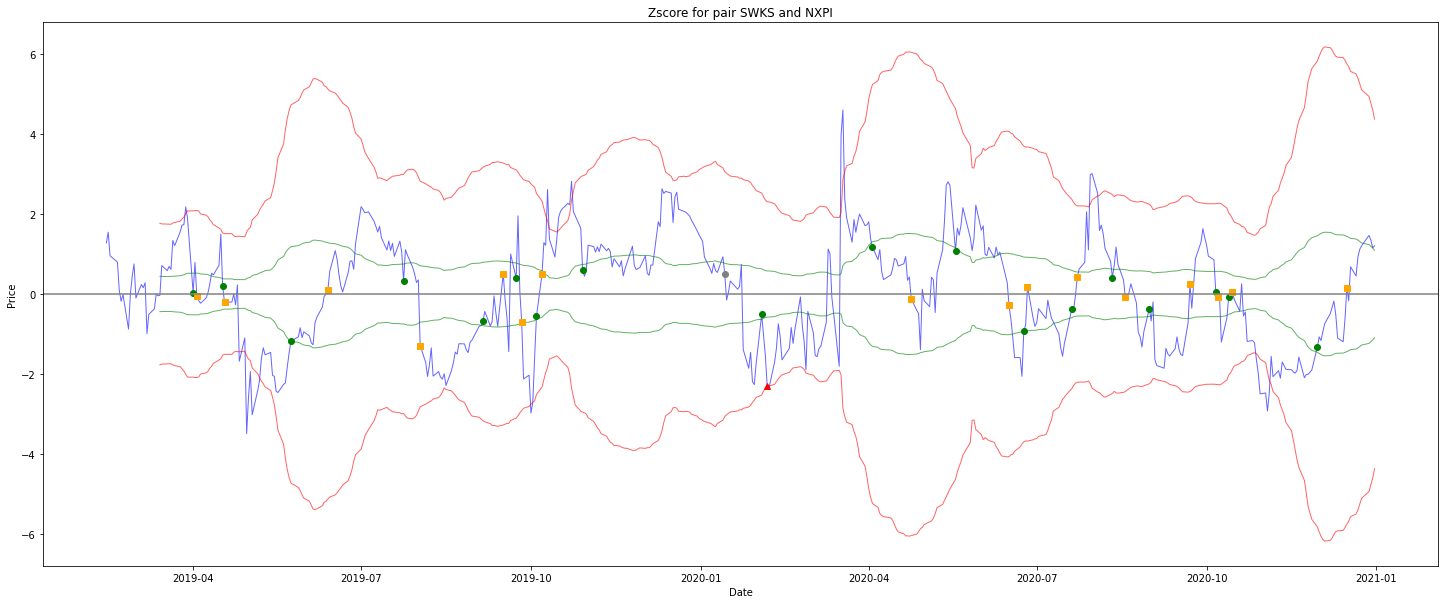

/tmp/ipykernel_161/332524862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["2STD_Log_Ratio"] =  stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["-2STD_Log_Ratio"] = -stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

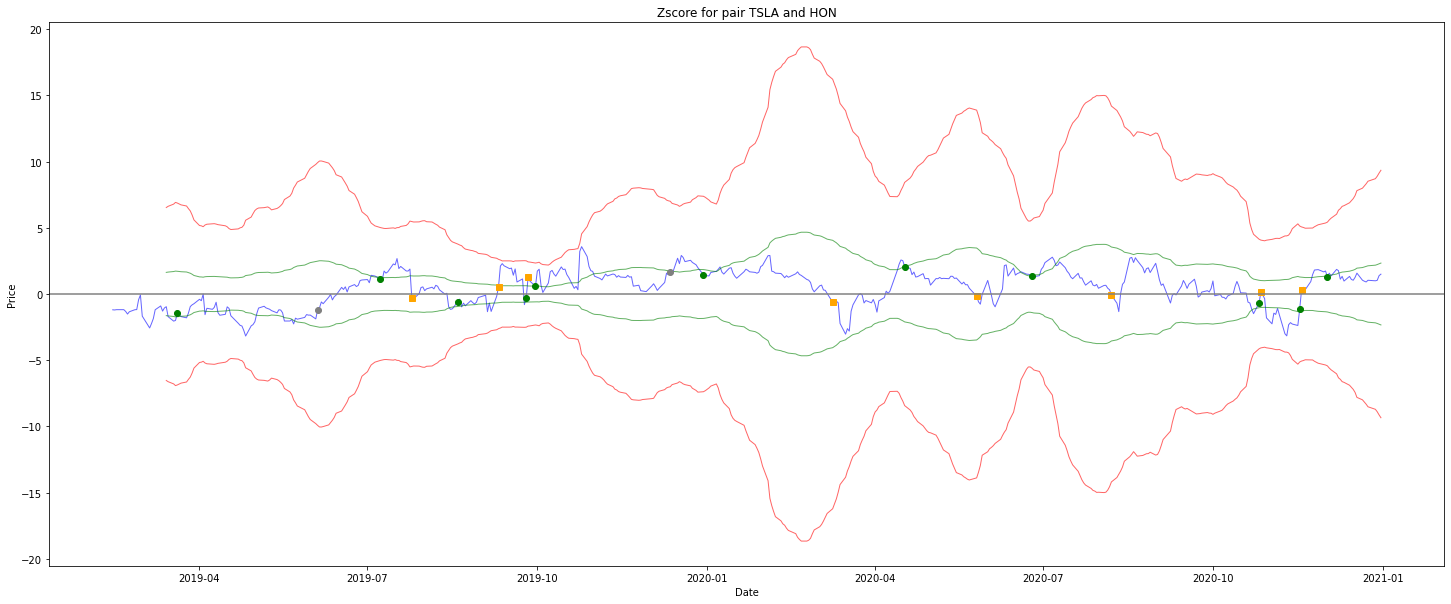

/tmp/ipykernel_161/332524862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["2STD_Log_Ratio"] =  stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["-2STD_Log_Ratio"] = -stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

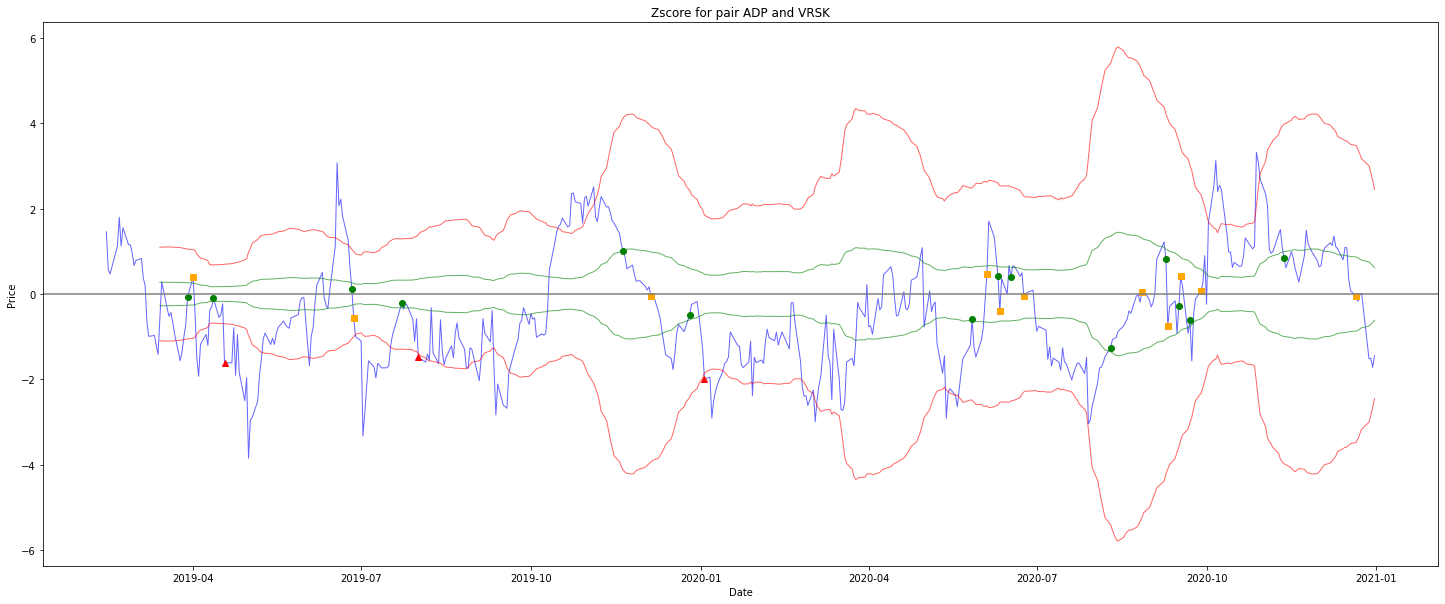

/tmp/ipykernel_161/332524862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["2STD_Log_Ratio"] =  stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["-2STD_Log_Ratio"] = -stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

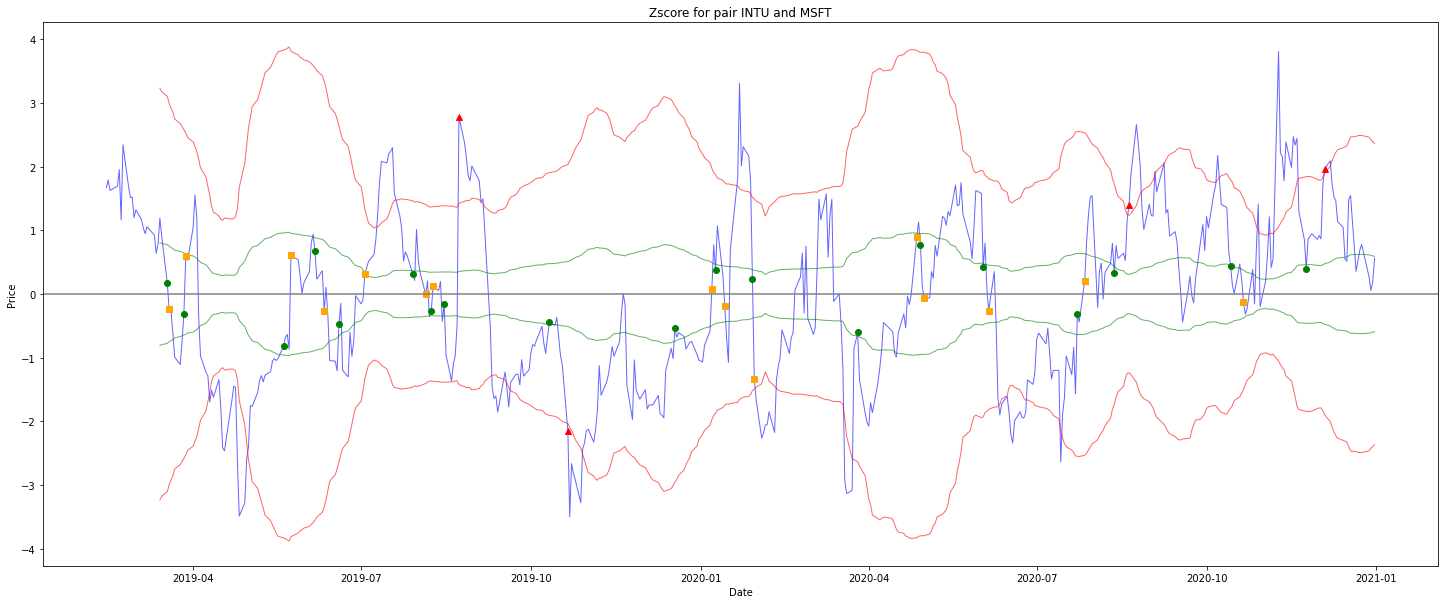

/tmp/ipykernel_161/332524862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["2STD_Log_Ratio"] =  stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["-2STD_Log_Ratio"] = -stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

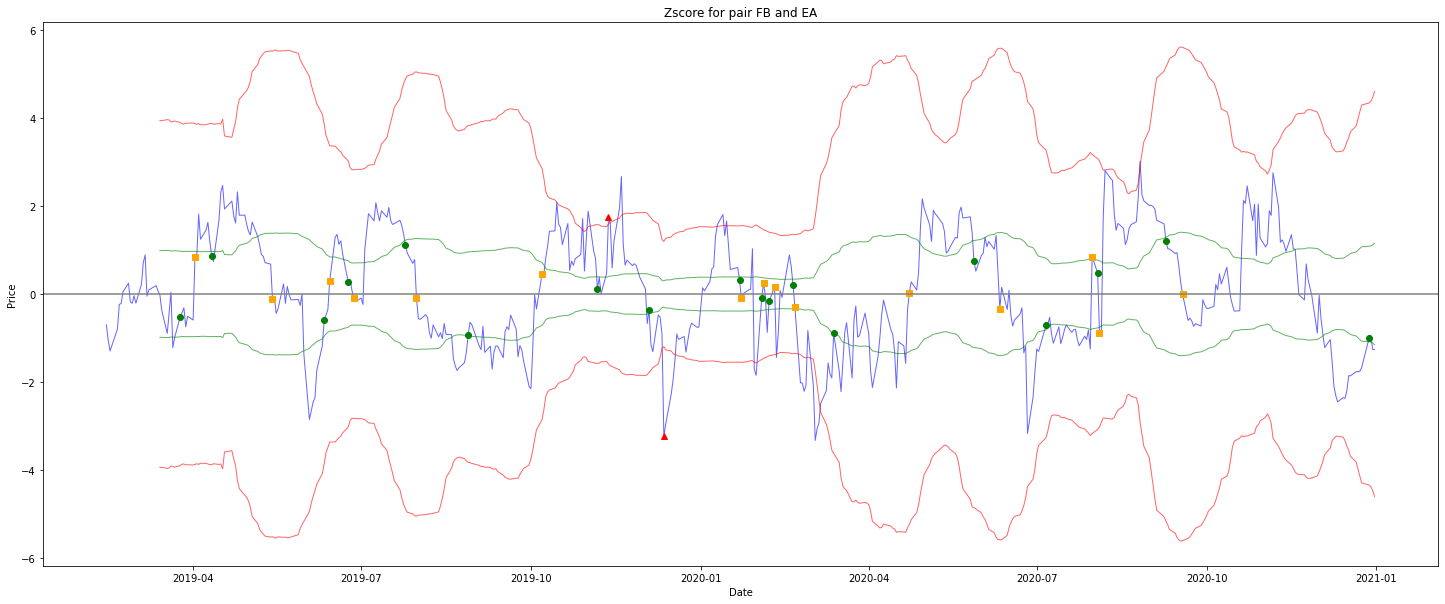

/tmp/ipykernel_161/332524862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["2STD_Log_Ratio"] =  stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["-2STD_Log_Ratio"] = -stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

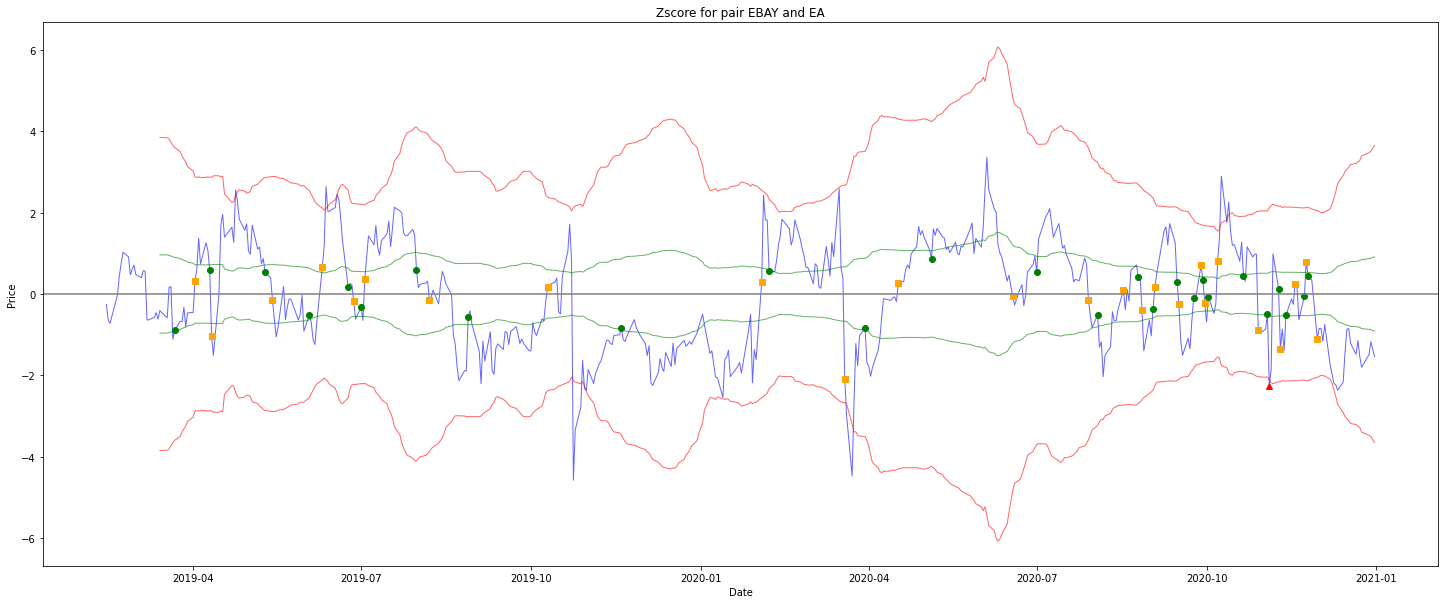

/tmp/ipykernel_161/332524862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["2STD_Log_Ratio"] =  stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["-2STD_Log_Ratio"] = -stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

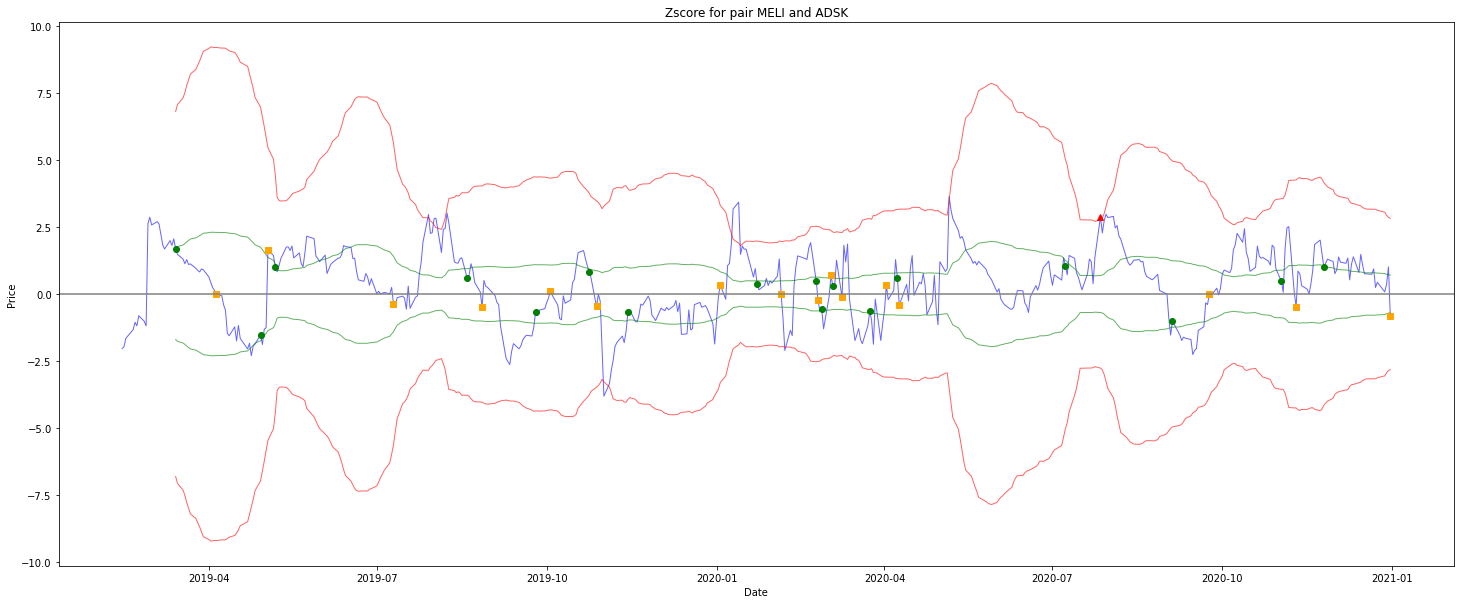

/tmp/ipykernel_161/332524862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["2STD_Log_Ratio"] =  stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["-2STD_Log_Ratio"] = -stoploss_value * df['STD_Log_Ratio']
/tmp/ipykernel_161/332524862.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

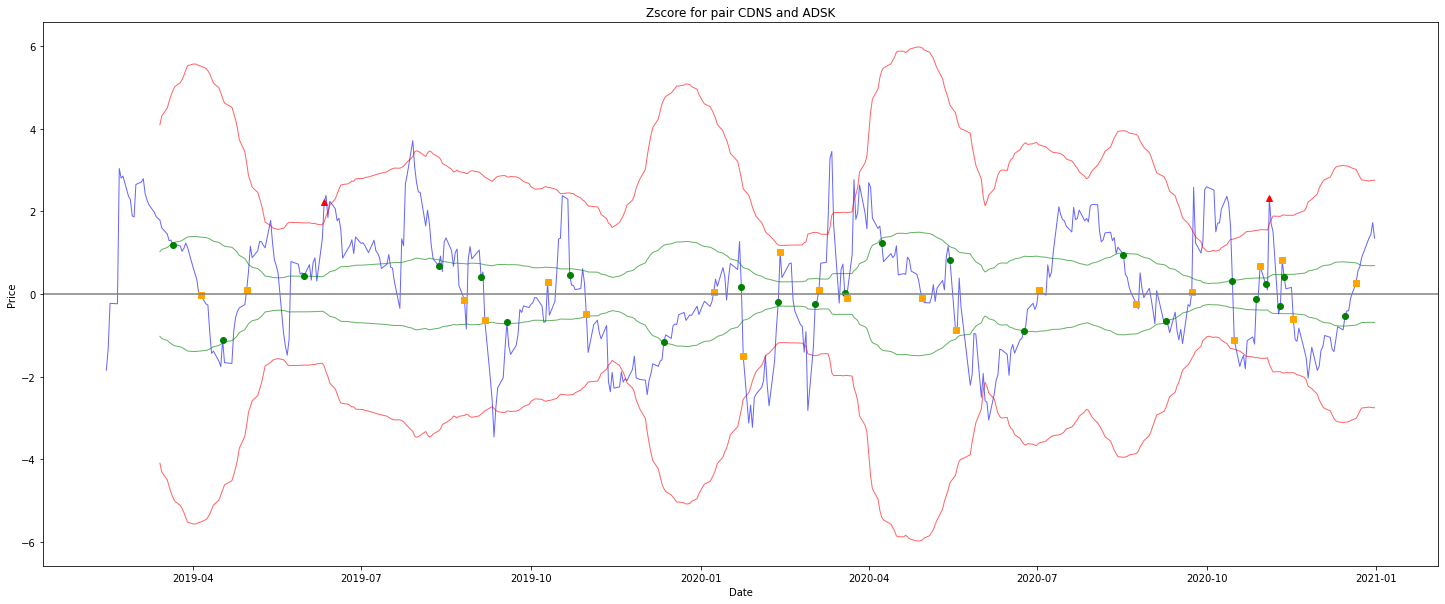

In [233]:
for i in range(len(df_test)):
    graph_invest2(df_test[i],stoploss_value)

In [234]:
def display_profit(df_list):
    df_profit = pd.DataFrame(columns=['Name_A','Name_B','Profit'])
    index = 0
    for i in range(len(df_list)):
        df_profit = pd.concat([df_profit, pd.DataFrame(data = {'Name_A':df_list[i].columns[1], 'Name_B':df_list[i].columns[2], 'Profit':df_list[i].Total.iloc[-1]}, index = [index])])
        index += 1
    return df_profit

In [235]:
df_final = display_profit(df_test)

In [236]:
print(df_final)

  Name_A Name_B        Profit
0   SWKS   NXPI  12451.337615
1   TSLA    HON   4374.707079
2    ADP   VRSK  13151.113794
3   INTU   MSFT  13203.320984
4     FB     EA   12453.37113
5   EBAY     EA  13805.309835
6   MELI   ADSK  14084.211161
7   CDNS   ADSK  14855.594906


In [237]:
print("Le rendement de la stratégie est de {}% sur la période de test".format((df_final.Profit.sum() / cash -1) * 100))

Le rendement de la stratégie est de -1.6210334959967265% sur la période de test


In [238]:
def Sharpe(df):
    df["Log_Return"] = np.log(df["Total"] / df["Total"].shift(1))
    L = abs(list(df[df["Log_Return"] != 0].Log_Return.rolling(window=100).mean()/df[df["Log_Return"] != 0].Log_Return.rolling(window=100).std()))
    plt.plot([i for i in range(len(L))],L)
    plt.show()

In [239]:
Sharpe(df_test[0])

/tmp/ipykernel_161/3211896842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Log_Return"] = np.log(df["Total"] / df["Total"].shift(1))


TypeError: bad operand type for abs(): 'list'

In [ ]:
def backtesting_strategy(cache, test, cash):
    freq_reb = 30 #jours
    '''
    wallet = copy.deepcopy(test)
    wallet = test.copy()
    start_date = test[0].loc[0,['Date']]
    current_date = start_date
    end_date = test[0].loc[len(test[0]),['Date']] 
    '''
    if method = "agressif": #augmenter les moyennes mobiles
    
    wallet = [invest(df, 1, 0, 2.5, cash/len(test),window) for df in test]
            
        

    
    for i in range(3#len(test)):
        if 
        # Séparation fenêtre glissante train/test (date de début et fin en paramètre) AVEC DES INDICES
        train,test = sep_tableau_train_test(combinations, train_start, train_end)    # Split Data between train and test with their date
        # Pair Selection (Cointegration + Stationarity)
        train = add_coint(train)
        train, ratio_score, log_score, same = pair_selection(train)
        train_list = [list(x.columns)[:3] for x in train]
        for j in range(len(wallet)):
            if list(wallet[j].columns[:3]) in train_list:
                wallet[j]['Selected'].loc[(wallet[j]['Date'] >= test_start) & (wallet[j]['Date'] < addMonths(test_start))] = True
                
                #print(wallet[j][(wallet[j]['Date'] >= test_start) & (wallet[j]['Date'] < addMonths(test_start))])
        # test[0]
        # w = (test[2]['Date'] >= np.datetime64('2019-01-02')) & (test[2]['Date'] < np.datetime64('2019-02-01'))

        # test[2]['Selected'] = w
        # test[2]
        # On lance l'investissement sur le test
        #test = calcul_moyenne_mobile(copy.deepcopy(test))
        test_invest = [invest(df, 1, 0, 2.5, 100000) for df in test]
        test_final.append(display_profit(test_invest,train))
        # On incrémente d'un mois
        #print(f"Pair n°{len(test_final)} Train date from {train_start} to {train_end}")
        
        # Incrémentation d'un mois de toutes les dates
        test_start = addMonths(test_start)
        train_start = addMonths(train_start)
        train_end = addMonths(train_end)
                          
    return test_final

In [ ]:
#plot = strat_by_pair(cache, df_combi)

In [ ]:
plot[0],plot[1],plot[2]

# Others

In [ ]:
def linear_regression(df): #prends en entrée un dataframe représentant une paire
# Engle-Granger method (spread method)
    S1=df[df.columns[1]]
    S2=df[df.columns[2]]
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[df.columns[1]]
    b = results.params[df.columns[1]]
    spread = S2 - b * S1
    df['Spread']=spread
    ''' Plot for seeing 
    spread.plot(figsize=(12,6))
    plt.axhline(spread.mean(), color='black')
    plt.legend(['Spread']);
    '''
    return df

In [ ]:
def rendement(df,j):
    #calculate the yield of the last j days
    rend1=[0 for i in range(j)]
    rend2=[0 for i in range(j)]
    for i in range(j,df.shape[0]):
        rend1.append((df.loc[i,df.columns[1]]-df.loc[i-j,df.columns[1]]) / df.loc[i-j,df.columns[1]])
        rend2.append((df.loc[i,df.columns[2]]-df.loc[i-j,df.columns[2]]) / df.loc[i-j,df.columns[2]])
    df["Rend_" + df.columns[1]]=rend1 
    df["Rend_" + df.columns[2]]=rend2 
    return df

In [ ]:
def volatility(df,j):
    vol1=[0 for i in range(j)]
    vol2=[0 for i in range(j)]
    for i in range(j,df.shape[0]):
        vol1.append(df[df.columns[1]][i-j:i].std())
        vol2.append(df[df.columns[2]][i-j:i].std())
    df["Vol_" + df.columns[1]]=vol1 
    df["Vol_" + df.columns[2]]=vol2 
    return df
    

In [ ]:
 find_stationarity(list_pairs) # All pair1-pair2 are not stationary (it makes sense)

In [ ]:
for i in range(len(list_pairs)):
    if len(list_pairs[i])!=0:
        for j in range(len(list_pairs[i])):
            list_pairs[i][j]=linear_regression(list_pairs[i][j])
            list_pairs[i][j]=zscore(list_pairs[i][j])
            if list_pairs[i][j] is False: #we verify that each zscore series is stationary
                print(list_pairs[i][j].columns[2]+" - "+ list_pairs[i][j].columns[1] + " not stationary")
            list_pairs[i][j]=volatility(list_pairs[i][j],30)
            

            
            
list_pairs[13][0]["Zscore"].plot(figsize=(12,6))
plt.axhline(list_pairs[13][0]["Zscore"].mean())
plt.axhline(list_pairs[13][0]["Zscore"].std(), color='red')
plt.axhline(-list_pairs[13][0]["Zscore"].std(), color='green')
plt.show()

In [ ]:
print(list_pairs[13][0])
print(adfuller(list_pairs[13][0]["Zscore"])[1])